In [327]:
%matplotlib inline

import numpy as np
import sys
import time
import os
import re
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')

In [7]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.proc_beh import get_all_transition, get_transitions_state, build_poke_df
from mecll.proc_neural import get_all_resps, get_mean_resps

In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [487]:
#Load behavioural data
root_path = '/Users/yves/Downloads/example_files/'

all_fs = os.listdir(root_path)

task_path = os.path.join(root_path,[i for i in all_fs if '.txt' in i][0])
lines = open(task_path,'r').readlines()


#load neural data timestamps

sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [488]:
len(spkT)

10766268

In [489]:
#Extract the timestamps of the sync-pulses between the neural data and the behavioural data
events = eval(lines[9][2:])
bnc_ev = events['BNC_input']
sync_messages_task =[int(re.findall(r' ([0-9]*)',l)[0]) for l in lines if str(bnc_ev)+'\n' in l and l[0]=='D']
poke_event_ids = [events['poke_'+str(i)] for i in range(1,10)]
print(poke_event_ids)

[7, 9, 11, 13, 15, 17, 19, 21, 23]


In [490]:
#align neural and behavioural timestamps
aligner = Rsync_aligner(sync_messages_spk,np.array(sync_messages_task)[1:],units_A=1/30.,units_B=1)

In [491]:
def build_poke_df(lines,events,sync_thing=0):
    
    df = pd.DataFrame(columns=['target','port','state','task_nr','direction','in_timeout','n_timeouts','probe','correct',
                               'previous_port','previous_state','reward','block_nr','task_repeat_nr','port_repeat','next_correct',
                               'frac_corr','RT','time','current_sequence','graph_type' #behavioural variables
                              ]) 
    
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    current_block_number = -1
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            #if poke_dict is not None:
            #    all_poke_dict.append(cp.deepcopy(poke_dict))
            #poke_dict = {}
            current_block_number += 1
            current_task = re.findall(r'task_number([0-9])',l)[0]
            current_sequence = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            current_graph_type = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]
            #poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            #poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            #poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            if len(df)>1:
                previous_port = df.iloc[-1]['port']
                previous_state = current_sequence.index(int(previous_port))
                if not df.iloc[-1]['correct']:
                    current_is_repeat = True
                    df.loc[len(df)-2,'next_correct'] = False

                else:
                    current_is_repeat = False
                    df.loc[len(df)-2,'next_correct'] = True

            else:
                previous_port = None
                previous_state = None
                current_is_repeat = False
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            
                
                
            
            #print(current_sequence)
            if len(rew_hist)>2:
                poke_dct = {
                          'target': int(target),
                          'port': int(poke),
                          'state': current_sequence.index(int(poke)),
                          'task_nr': current_task,
                          'direction': direction,
                          'in_timeout': False,
                          'n_timeouts': np.nan,
                          'probe': probe,
                          'correct': poke==target,
                          'reward': n_rew==rew_hist[-2],
                          'block_nr':current_block_number,
                          'task_repeat_nr': int(np.floor(current_block_number/2)),
                          'frac_corr': None,
                          'RT':None,
                          'time':t_,
                          'current_sequence': current_sequence,
                          'graph_type': current_graph_type,
                          'port_repeat':current_is_repeat,
                          'previous_port': previous_port,
                          'previous_state': previous_state,
                                  }
                df = df.append(poke_dct,ignore_index=True)

       
    return df
    

if u really have a spatial cell, then I guess you . There are some spatial cells with multiple fields. However, we know that the number of fields should follow a gamma-exponential distribution as it does in space.

In [492]:
def build_DM(port_df,two_task_regs=0):
    
    """ Build a design matrix for predicing neural activity from this. 
        In this version do not resolve time, in other words we are just
        trying to predict the responses to each task
        
        For pure null model
        Features: port number
                  inbound HD direction (this will just be up/down, left/right)
                  outbound HD direction (this will just be up/down, left/right)
                  reward
                  correct
        
        So total dim is 9 + 2 + 2 + 1 + 1
                  
                
        For complicated model:
                port number x task
                  
                  
    """
    
    two_task_regs = int(two_task_regs)
    DM = np.zeros([14+9*two_task_regs,len(df)])
    for nr,row, in df.iterrows():
        port_reg = np.zeros(9+9*two_task_regs)
        port_reg[row['port'] + two_task_regs*9*int(row['task_nr'])] = 1
        
        
        angle_reg = get_angle_between_ports_as_vec(row['port'],row['previous_port'])
        
        rew_reg = [row['reward']]
        correct_reg = [float(row['correct'])]

        all_regs = np.concatenate([[1],port_reg,angle_reg,rew_reg,correct_reg])
        DM[:,nr] = all_regs
    return DM

In [493]:
def get_angle_between_ports(port1_id,port2_id):
    if port1_id is None or port2_id is None:
        angle = None
    else:
        port1_id = np.flipud(poke_pos[port1_id])
        port2_id = np.flipud(poke_pos[port2_id])
        print(port1_id[0]-port2_id[0],port1_id[1]-port2_id[1])
        myradians = np.math.atan2(port1_id[0]-port2_id[0],port1_id[1]-port2_id[1])
        angle = myradians*(180/np.pi)
    return angle


In [494]:
def get_angle_between_ports_as_vec(port1_id,port2_id):
    if port1_id is None or port2_id is None:
        angle = np.zeros(2)
    else:
        port1_id = np.flipud(poke_pos[port1_id])
        port2_id = np.flipud(poke_pos[port2_id])
        angle = np.array([port1_id[0]-port2_id[0],port1_id[1]-port2_id[1]])
        angle = angle/np.sum(np.abs(angle))
        #myradians = np.math.atan2(port1_id[0]-port2_id[0],port1_id[1]-port2_id[1])
        #angle = myradians*(180/np.pi)
    return angle


In [495]:
df = build_poke_df(lines,events)


In [496]:
DM = build_DM(df)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [497]:
poke_dict ={}

for port_nr in np.unique(df['port'].values):

    v = df.loc[(df['port']==port_nr)]['time'].values

    poke_dict[str(port_nr)] = [float(i) for i in v]


In [499]:
len(df)

1255

In [501]:
st = time.time()
used_pokes = np.zeros(len(df))
window0 = 3000
window1 = 6000
scaleF = (window0+window1)/30000.
all_spk_store = []

for unit in single_units:#
    spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell
    spk_store = []
    for nr,row in df.iterrows():
        aligned_T = aligner.B_to_A(row['time'])
        
        if not np.isnan(aligned_T):

            tpk = aligned_T
            spike_locs = np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1))
            nSpikes = len(np.where(spike_locs)[0])
            firing_rate = scaleF*float(nSpikes)
            spk_store.append(firing_rate)
            used_pokes[nr] = 1
    all_spk_store.append(spk_store)
            #1+1
print('elapsed time: {:.2f}'.format(time.time() - st))

elapsed time: 57.44


# Now want to run several analyses

1. Does including head direction improve model performance
2. Does having separate things for two tasks improve model performance

In [502]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import scipy.stats as stt

In [503]:
all_spk_store = np.array(all_spk_store)

In [504]:
DM = build_DM(df,two_task_regs=1)
DM_used = DM[:,np.where(used_pokes)[0]]
DM_used[np.where(~np.isfinite(DM_used))] = 0

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [505]:
all_spk_store.shape

(320, 1238)

In [507]:
DM_used.shape

(23, 1238)

In [509]:
DM = build_DM(df,two_task_regs=1)
DM_used = DM[:,np.where(used_pokes)[0]]
DM_used[np.where(~np.isfinite(DM_used))] = 0

seed = 97
scores_w_two_tasks = []
n_neurons = all_spk_store.shape[0]
for neuron_ix in range(n_neurons):
    neuron_rates = np.array(all_spk_store)[neuron_ix]
    X_train, X_test, y_train, y_test = train_test_split(DM_used.T,neuron_rates,test_size=0.4,random_state=seed)
    lin_reg.fit(X_train,y_train)
    scores_w_two_tasks.append(lin_reg.score(X_test,y_test))
    

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [510]:
DM = build_DM(df,two_task_regs=0)
DM_used = DM[:,np.where(used_pokes)[0]]
DM_used[np.where(~np.isfinite(DM_used))] = 0


scores_wo_two_tasks = []
n_neurons = all_spk_store.shape[0]
for neuron_ix in range(n_neurons):
    neuron_rates = np.array(all_spk_store)[neuron_ix]
    X_train, X_test, y_train, y_test = train_test_split(DM_used.T,neuron_rates,test_size=0.4,random_state=seed)
    lin_reg.fit(X_train,y_train)
    scores_wo_two_tasks.append(lin_reg.score(X_test,y_test))
    

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [511]:
scores_w_two_tasks = np.array(scores_w_two_tasks)
scores_wo_two_tasks = np.array(scores_wo_two_tasks)

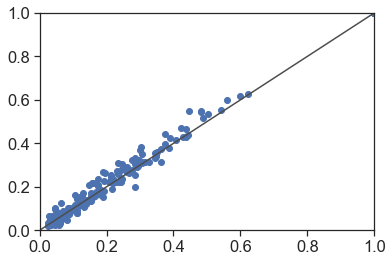

In [512]:
ixs_ = np.where(np.logical_and(scores_w_two_tasks>0.02,scores_wo_two_tasks>0.02))[0]
plt.scatter(scores_wo_two_tasks[ixs_],scores_w_two_tasks[ixs_])
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],color='.3')

In [513]:
np.mean(scores_w_two_tasks[ixs_])

0.22341729369047678

In [514]:
np.mean(scores_wo_two_tasks[ixs_])

0.21366859363161086

# Compare with and without head direction 

In [526]:
DM = build_DM(df,two_task_regs=1)
DM_used = DM[:,np.where(used_pokes)[0]]
DM_used[np.where(~np.isfinite(DM_used))] = 0

seed = 97
scores_w_two_tasks = []
n_neurons = all_spk_store.shape[0]
for neuron_ix in range(n_neurons):
    neuron_rates = np.array(all_spk_store)[neuron_ix]
    X_train, X_test, y_train, y_test = train_test_split(DM_used.T,neuron_rates,test_size=0.4,random_state=seed)
    lin_reg.fit(X_train,y_train)
    scores_w_two_tasks.append(lin_reg.score(X_test,y_test))
    

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [527]:
DM_used = np.delete(DM_used,-3,axis=0)
DM_used = np.delete(DM_used,-3,axis=0)

scores_wo_two_tasks = []
n_neurons = all_spk_store.shape[0]
for neuron_ix in range(n_neurons):
    neuron_rates = np.array(all_spk_store)[neuron_ix]
    X_train, X_test, y_train, y_test = train_test_split(DM_used.T,neuron_rates,test_size=0.4,random_state=seed)
    lin_reg.fit(X_train,y_train)
    scores_wo_two_tasks.append(lin_reg.score(X_test,y_test))
    

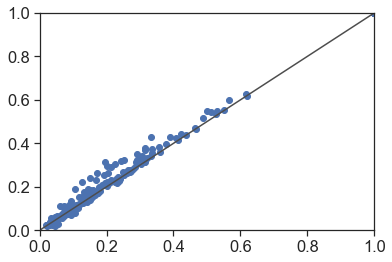

In [528]:
scores_w_two_tasks = np.array(scores_w_two_tasks)
scores_wo_two_tasks = np.array(scores_wo_two_tasks)

ixs_ = np.where(np.logical_and(scores_w_two_tasks>0.02,scores_wo_two_tasks>0.02))[0]
plt.scatter(scores_wo_two_tasks[ixs_],scores_w_two_tasks[ixs_])
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],color='.3')

In [529]:
np.mean(scores_w_two_tasks[ixs_])

0.2223131683842259

In [530]:
np.mean(scores_wo_two_tasks[ixs_])

0.20928784595094954

In [531]:
stt.ttest_rel(scores_w_two_tasks[ixs_],scores_wo_two_tasks[ixs_])

Ttest_relResult(statistic=7.299451155025607, pvalue=7.246954985446707e-12)

# Now lets get the simulated responses

In [533]:
DM = build_DM(df,two_task_regs=0)
DM_used = DM[:,np.where(used_pokes)[0]]
DM_used[np.where(~np.isfinite(DM_used))] = 0

seed = 97
scores = []
predictions = []
n_neurons = all_spk_store.shape[0]
for neuron_ix in range(n_neurons):
    neuron_rates = np.array(all_spk_store)[neuron_ix]
    X_train, X_test, y_train, y_test = train_test_split(DM_used.T,neuron_rates,test_size=0.4,random_state=seed)
    lin_reg.fit(X_train,y_train)
    predictions.append(lin_reg.predict(DM_used.T)) #these are the predictions of neural activity
    scores_w_two_tasks.append(lin_reg.score(X_test,y_test))
    

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [534]:
predictions = np.array(predictions)

In [535]:
predictions.shape

(320, 1238)